In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import least_squares
import math

# 1. Defining Functions

## Single First Order Reaction

In [2]:
T_ref = 27
gas_const = scipy.constants.gas_constant
# [[A]_0, k(T_ref), E_a]
single_params = np.array([97.9, (7.4 * 10**(-5)) ,115.83]) # purity of nr ce-sds

def single_rate_constant(T, kT_ref, E_a):
    e = math.e**(((-E_a)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_ref * e)

def A_single (params, t,T):
    k = single_rate_constant(T, params[1], params[2])
    e = math.e**((-1)* k *t)
    return (params[0] * e)

def B_single(params, t, T, B_0):
    A = A_single(params, t, T)
    return (B_0 + params[0] - A)

## Parallel First Order Reaction

In [48]:
# [[A]0, [B]0, kB(Tref), kC(Tref), Ea,B, Ea,C]
parallel_params = [99.1, 0.9, 6.13 * (10 ** (-5)), 1.25 * (10 ** (-4)), 111.45, 103.32]

def parallel_rate_constant(T, kT_refX, E_aX):
    e = math.e**(((-E_aX)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_refX * e)

def A_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*( k_b + k_c )*t)
    return (params[0] * e)

"""
For B and C, we are taking the assumption given in the article that: 

[B] = [A]_0\frac{k_b}{k_b + k_c} ...

where k_b and k_c would be txhe rate czonstant of the reference temperature
"""
def B_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[2] / total_k) * (1 - e)
    return (x - params[1])
    
def C_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[3] / total_k) * (1 - e)
    # [C]_0 = 100 - ([A]_0 + [B]_0
    return (x - (100 - (params[0] + params[1])))

## Single N-th Order Reaction

In [4]:
# [[A]_0, k(T_ref), E_a, N]
single_n_params = np.array([99.6, (5.63 * 10**(-4)) ,120, 0])

def A_n_single(params, t, T):
    k = single_rate_constant(T, params[1], params[2])
    A = (params[0] ** (1 - params[3])) - k * t * (1-params[3])
    return (A ** (1/(1-params[3])))
            
def B_n_single(params, t, T):
    A = A_n_single(params, t, T)
    return (100 - A)

# 2. Test with Data (AI-Generated Data)

In [5]:
df = pd.read_csv('sample.csv')
df['[B]'] = df['[B] HMW'] + df['[C] LMW']

t0_df = df[df['Time (months)'] == 0]
t1_df = df[(df['Time (months)'] == 1) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t3_df = df[(df['Time (months)'] == 3) & (df['Temp (K)'].isin([278.15, 298.15, 313.15]))]
t6_df = df[(df['Time (months)'] == 6) & (df['Temp (K)'].isin([278.15, 298.15]))]

df_train = pd.concat([t0_df, t1_df, t3_df, t6_df], ignore_index=True)
df_train

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.100000,99.100000,0.000000,0.000000,0.000000
1,0,25,298.15,99.100000,99.100000,0.000000,0.000000,0.000000
2,0,40,313.15,99.100000,99.100000,0.000000,0.000000,0.000000
3,1,5,278.15,99.099142,99.099142,0.000240,0.000619,0.000858
4,1,25,298.15,99.081539,99.081539,0.006074,0.012386,0.018461
5,1,40,313.15,98.956546,98.956546,0.052304,0.091150,0.143454
6,3,5,278.15,99.097425,99.097425,0.000719,0.001856,0.002575
7,3,25,298.15,99.044628,99.044628,0.018219,0.037152,0.055372
8,3,40,313.15,98.670261,98.670261,0.156685,0.273054,0.429739
9,6,5,278.15,99.094851,99.094851,0.001438,0.003711,0.005149


In [6]:
df[df['Time (months)'] == 0]

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278.15,99.1,99.1,0.0,0.0,0.0
37,0,25,298.15,99.1,99.1,0.0,0.0,0.0
74,0,40,313.15,99.1,99.1,0.0,0.0,0.0


### real data

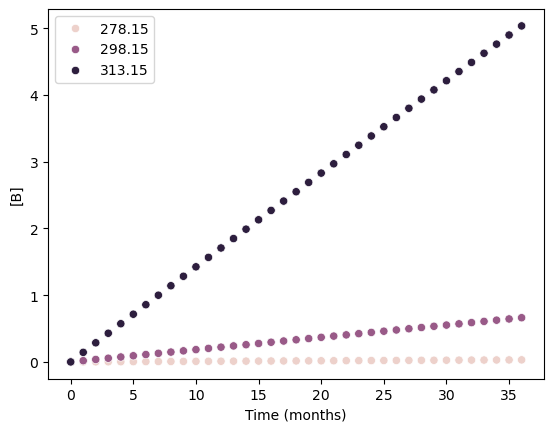

In [7]:
sns.scatterplot(x = df['Time (months)'], y = df['[B]'], hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

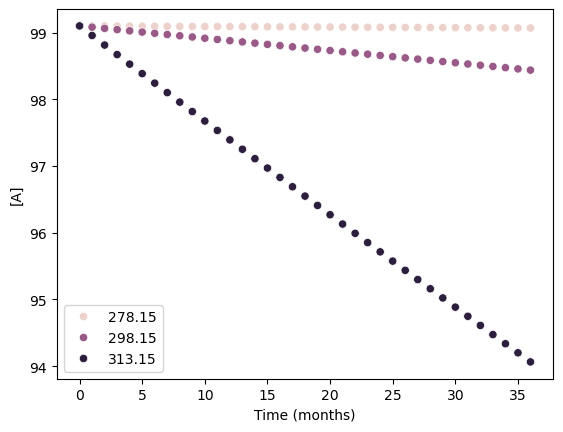

In [8]:
sns.scatterplot(x = df['Time (months)'], y = df['[A] Monomer (single)'], hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

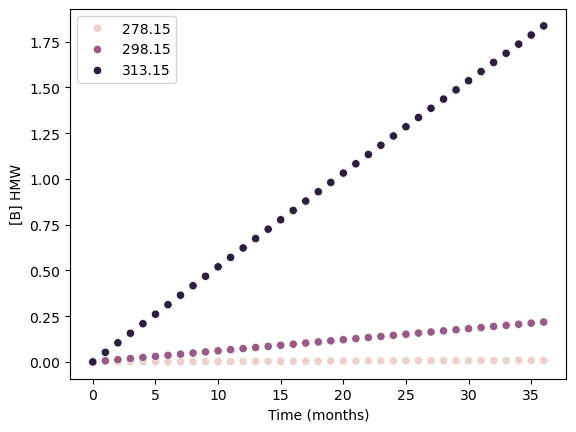

In [52]:
sns.scatterplot(x = df['Time (months)'], y = df['[B] HMW'], hue = df['Temp (K)'])
plt.ylabel("[B] HMW")
plt.legend()
plt.show()

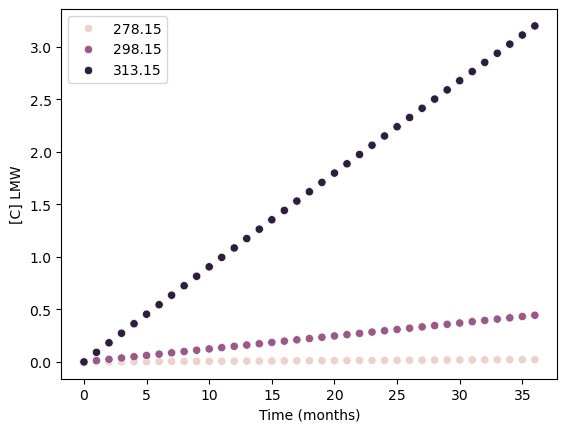

In [53]:
sns.scatterplot(x = df['Time (months)'], y = df['[C] LMW'], hue = df['Temp (K)'])
plt.ylabel("[C] LMW")
plt.legend()
plt.show()

## Single First-Order Reaction

In [9]:
initial_guess_single = np.array([100, (0.0005) , 120])

In [10]:
lower_bounds_single_first = [80, 0, 0]
upper_bounds_single_first = [100, np.inf, np.inf]


def residuals_B_single(params, combined_input_data, y_observed, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_observed - y_predicted

def batch_B_single(params, combined_input_data, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [33]:
result_B = least_squares(
    residuals_B_single,
    initial_guess_single,
    args=(df_train, df_train['[B]'], 0 ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_first, upper_bounds_single_first),
    verbose = 2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5663e-01                                    4.80e-01    
       1              2         1.1190e-01      1.45e-01       3.63e+01       1.10e-01    
       2              3         8.6967e-02      2.49e-02       2.14e+01       2.37e-02    
       3              4         8.4111e-02      2.86e-03       9.17e+00       3.72e-03    
       4              5         8.3994e-02      1.17e-04       1.65e+00       2.02e-04    
       5              6         8.3965e-02      2.97e-05       2.49e+01       1.34e+00    
       6              7         8.3917e-02      4.76e-05       4.98e+01       7.46e+00    
       7              9         8.3875e-02      4.22e-05       2.49e+01       1.30e+00    
       8             10         8.3827e-02      4.77e-05       4.98e+01       9.92e+00    
       9             12         8.3785e-02      4.21e-05       2.49e+01       1.75e+00    

In [34]:
new_params = result_B.x
new_params

array([8.00001772e+01, 1.32404959e-09, 3.05481411e+03])

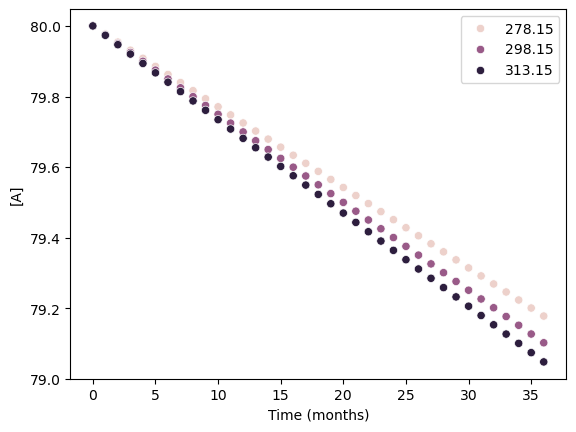

In [35]:
preds = batch_A_single(new_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

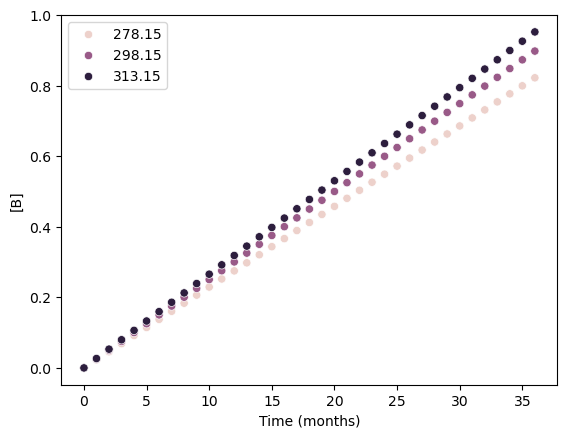

In [36]:
preds = batch_B_single(new_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

### using the supporting material's parameters

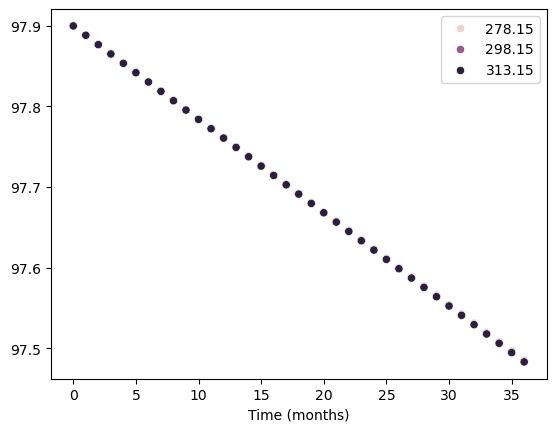

In [37]:
preds = batch_A_single(single_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

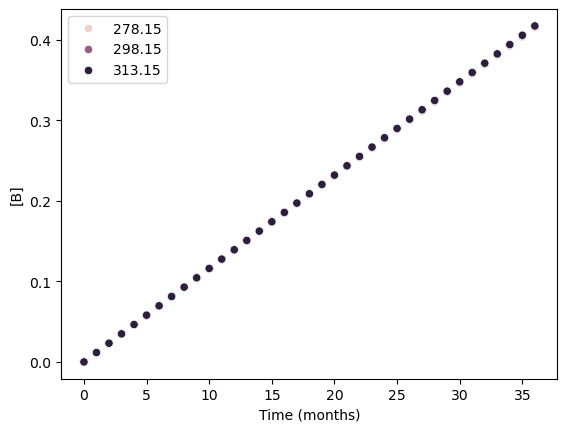

In [38]:
preds = batch_B_single(single_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

Looking at the parameters used on the purity acquired from NR CE-SDS, it seems that the data generated by GPT is somewhat imprecise as when we test the parameters, we acquire similar result just with the difference being $[A]_0$ and activation energy being higher when we try to fit the model with the data from GPT.

## Single N-th Order Reaction

In [39]:
lower_bounds_single_n = [80, 0, 0, -np.inf]
upper_bounds_single_n = [100, np.inf, np.inf, np.inf]

def residuals_B_n_single(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_observed - y_predicted
    
def batch_B_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [40]:
initial_guess_n_single = np.array([100, (0.0005) , 120, 0])

In [42]:
result_B_n = least_squares(
    residuals_B_n_single,
    initial_guess_n_single,
    args=(df_train, df_train['[B]'] ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_n, upper_bounds_single_n),
    verbose = 2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0862e-01                                    1.49e+01    
       1              2         7.9547e-02      2.91e-02       3.66e-02       3.67e-01    
       2              3         7.9429e-02      1.17e-04       4.84e+01       4.24e-04    
       3              4         7.9348e-02      8.15e-05       1.22e+02       8.84e-03    
       4              7         7.9347e-02      3.86e-07       1.42e-02       8.96e-03    
       5              9         7.9347e-02      3.08e-08       7.15e-03       3.00e-03    
       6             11         7.9347e-02      9.33e-09       3.58e-03       7.45e-04    
       7             12         7.9347e-02      1.29e-08       7.15e-03       3.09e-03    
       8             14         7.9347e-02      9.46e-09       3.58e-03       7.00e-04    
       9             15         7.9347e-02      1.27e-08       7.15e-03       3.18e-03    

In [43]:
new_params_n = result_B_n.x
new_params_n

array([9.99595612e+01, 5.83190288e-05, 2.90856779e+02, 9.25405093e-01])

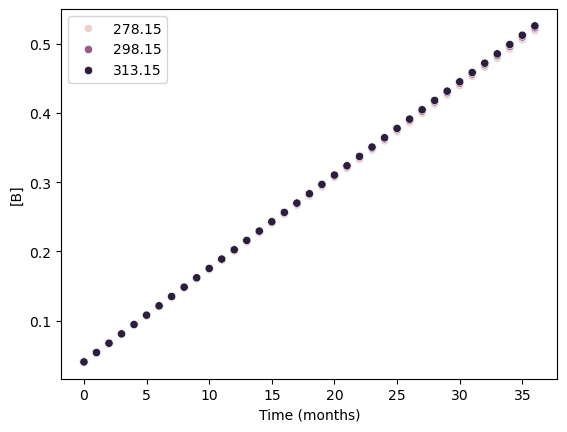

In [44]:
preds = batch_B_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

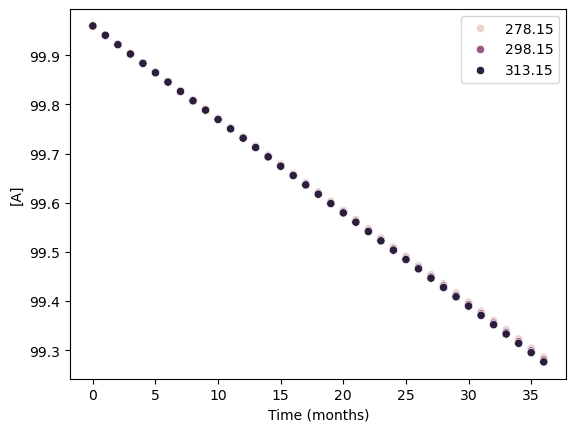

In [45]:
preds = batch_A_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

### using supported material's parameter (Monomer)

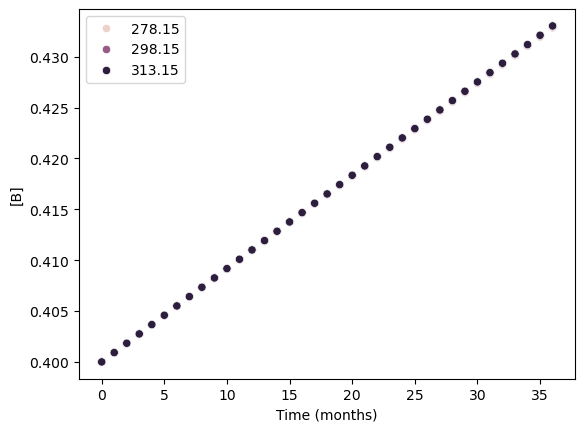

In [46]:
preds = batch_B_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

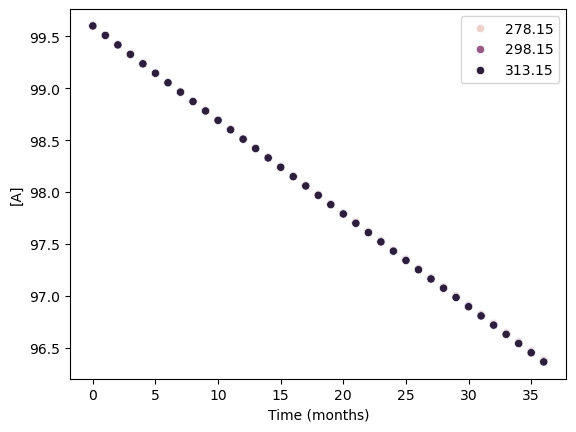

In [47]:
preds = batch_A_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

The values of the parameters in the n-th order reaction are closer to the supporting material's parameters. This would suggest that I need better data to fit the model.

## Parallel First Order Reaction

In [25]:
lower_bounds_parallel = [0.0, 0.0, 0.0, 0.0, -np.inf, -np.inf]
upper_bounds_parallel = [100.0, 100.0, np.inf, np.inf, np.inf, np.inf]
    
def residual_total_parallel(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    A_predicted = np.array([A_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    B_predicted = np.array([B_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    C_predicted = np.array([C_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])

    B_predicted_actual_conc = B_predicted 
    C_predicted_actual_conc = C_predicted 

    all_predictions = np.concatenate((A_predicted, B_predicted_actual_conc, C_predicted_actual_conc))

    return all_predictions - y_observed

def batch_A_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_B_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_C_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([C_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [26]:
initial_params = [95, 1, 0.0001, 0.0001, 400, 500]

In [27]:
target_parallel = np.concatenate((df_train['[A] Monomer (single)'].values, 
                                  df_train['[B] HMW'].values, 
                                  df_train['[C] LMW'].values))

In [28]:
result_parallel = least_squares(
    residual_total_parallel,
    initial_params,
    args=(df_train, target_parallel),
    bounds=(lower_bounds_parallel, upper_bounds_parallel),
    verbose=2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9048e+02                                    3.29e+03    
       1              2         4.6373e+01      1.44e+02       6.42e+02       1.13e+02    
       2              3         1.0536e+01      3.58e+01       1.28e+03       2.87e+01    
       3              4         2.5953e+00      7.94e+00       2.57e+03       6.87e+00    
       4              6         1.1810e+00      1.41e+00       6.30e+01       1.51e+00    
       5              7         1.0298e+00      1.51e-01       1.26e+02       2.15e-01    
       6              9         1.0255e+00      4.30e-03       6.25e+01       1.01e+03    
       7             11         1.0238e+00      1.69e-03       3.13e+01       1.39e+02    
       8             13         1.0236e+00      2.28e-04       1.56e+01       6.98e+01    
       9             14         1.0233e+00      3.47e-04       3.13e+01       3.58e+02    

The Dogbox method of optimisation is unsuitable as the optimality became NaN.

In [29]:
new_params_parallel = result_parallel.x
new_params_parallel

array([ 9.94679661e+01,  2.70533165e-01,  6.54148480e-09,  7.22207290e-09,
       -3.88219645e+03,  2.98621664e+03])

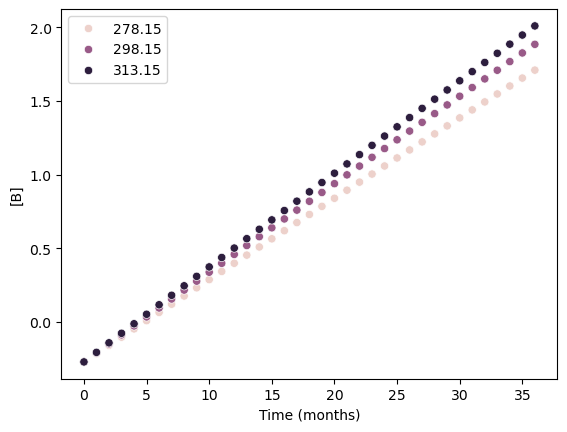

In [30]:
preds = batch_B_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

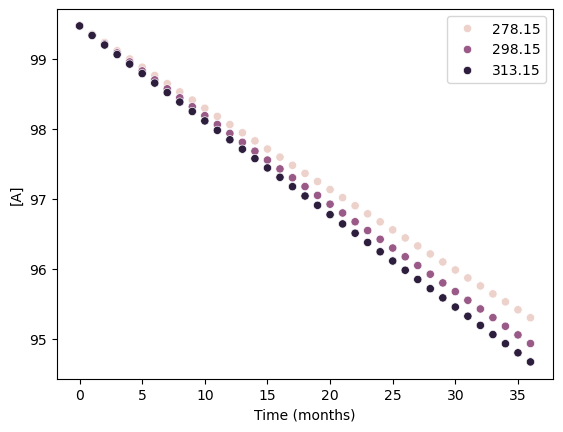

In [31]:
preds = batch_A_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

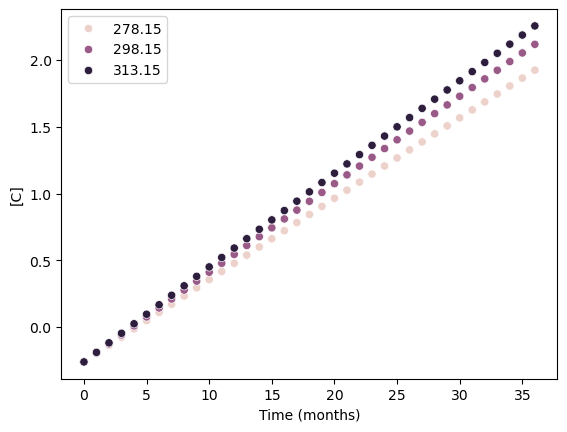

In [32]:
preds = batch_C_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[C]")
plt.legend()
plt.show()

Additionally, as I have been experimenting with only eleven total data points for training, where the data comes from one (AI-generated) drug product, it begs the question: were the predictors in the article fitted with other types of drugs too? If so, how can it be done? Keep in mind that every molecule would have a different rate constant and activation energies.

### Test with Supporting Material's Parameters

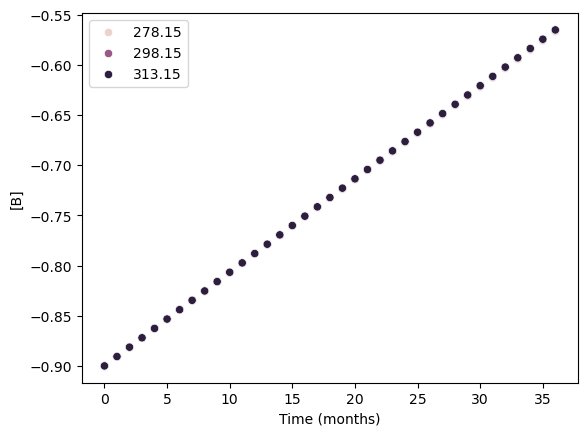

In [49]:
preds = batch_B_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

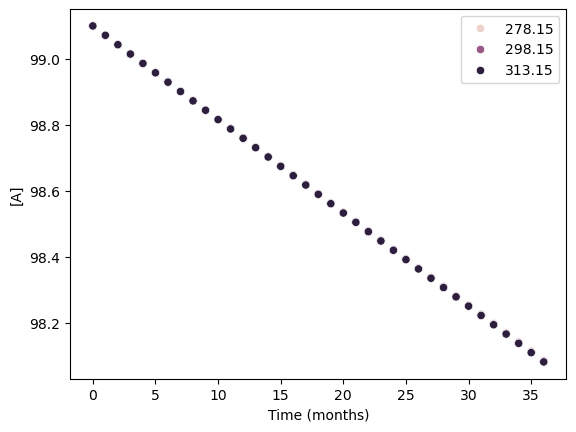

In [50]:
preds = batch_A_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

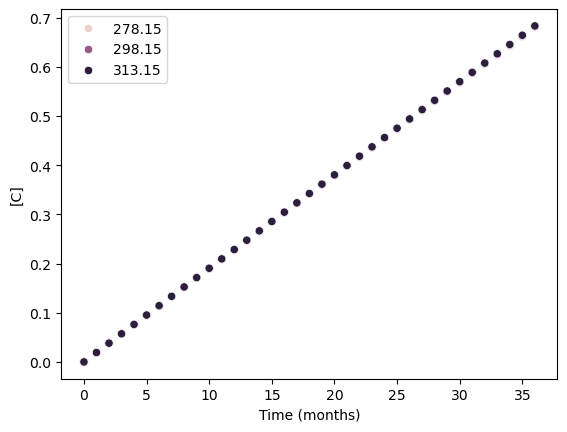

In [51]:
preds = batch_C_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[C]")
plt.legend()
plt.show()

There also seems to be an error of assumption as the dogbox method of optimisation is not suitable for a small sample size, as shown through the supporting material's parameters that utilised the dogbox method in least squares optimisation. 